<a href="https://colab.research.google.com/github/jeonghojo00/MachineLearning/blob/main/Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Select runtime

## GPU

In [ ]:
# Run only when Using GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Aug 30 05:15:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if DEVICE == 'cuda':
    torch.cuda.manual_seed_all(1234)
print(DEVICE)

cuda


#1. Data Exploration

In [2]:
# Mount google drive
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
mount='/content/drive'
drive_root = mount + "/MyDrive/Colab Notebooks/NLP/disaster_tweets"
%cd $drive_root

/content/drive/MyDrive/Colab Notebooks/NLP/disaster_tweets


In [4]:
import sys
import subprocess
import pkg_resources

required = {'transformers', 'datasets', 'torchmetrics', 'contractions', 'evaluate', 'gensim', 'optuna', 'ray[tune]'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

In [5]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertTokenizerFast
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, BertForSequenceClassification
from transformers import AdamW, get_scheduler
import re, string, unicodedata
import contractions
import inflect
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from gensim.parsing.preprocessing import remove_stopwords

In [6]:
txtfiles = []
for file in glob.glob("./distaster_tweets/*.csv"):
    txtfiles.append(file)
txtfiles

['./distaster_tweets/test.csv',
 './distaster_tweets/sample_submission.csv',
 './distaster_tweets/train.csv']

In [7]:
# Train file
train_file = txtfiles[2]
print(train_file)
train_df = pd.read_csv(train_file)

# Test file
test_file = txtfiles[0]
print(test_file)
test_df = pd.read_csv(test_file)

# Sample Submission file
sample_file = txtfiles[1]
print(sample_file)
sample_df = pd.read_csv(sample_file)

./distaster_tweets/train.csv
./distaster_tweets/test.csv
./distaster_tweets/sample_submission.csv


In [8]:
print("...Printing train_df")
display(train_df.head())
print("\n\n...Printing test_df")
display(test_df.head())
print("\n\n...Printing sample_df")
display(sample_df.head())

...Printing train_df


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1




...Printing test_df


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan




...Printing sample_df


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


{1: 3271, 0: 4342}


Text(0.5, 1.0, 'Distribution of the Target Label')

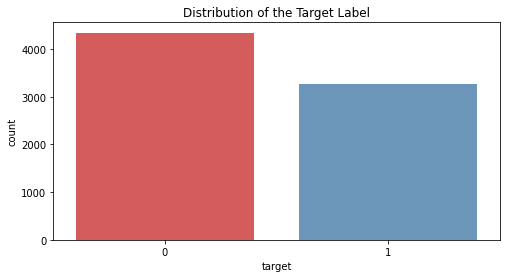

In [9]:
# target lable distribution
target_info = dict(Counter(train_df['target']))
print(target_info)
plt.figure(figsize = (8,4))
sns.countplot(x = train_df['target'], palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the Target Label')


Text(0.5, 1.0, 'Distribution of the word count')

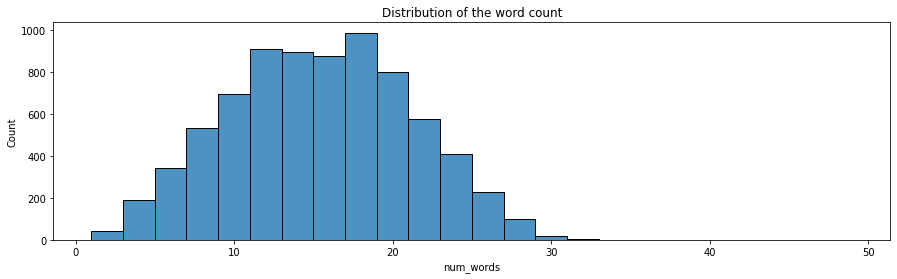

In [10]:
# words per message distribution
train_df['num_words'] = train_df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize = (15,4))
sns.histplot(train_df['num_words'], bins = range(1, 50, 2), palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the word count')

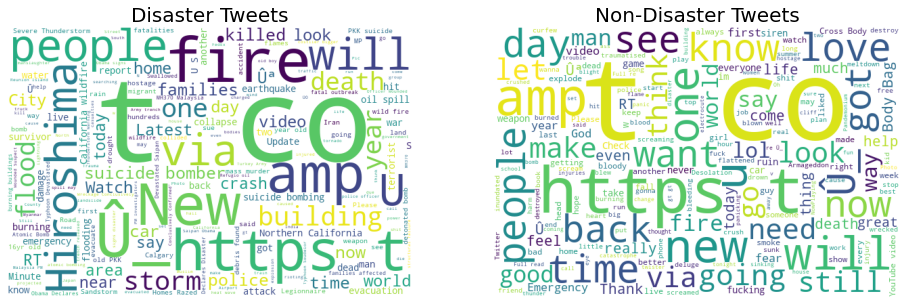

In [11]:
# Visualize in word cloud

disaster_tweets = train_df[train_df['target']==1]['text']
non_disaster_tweets = train_df[train_df['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=20);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non-Disaster Tweets',fontsize=20);

#2. Text Preprocessing

In [12]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# Text cleaning
def cleanText(df):
    df.text= df.text.apply(lambda x:x.lower() )
    #removing square brackets
    df.text= df.text.apply(lambda x:re.sub('\[.*?\]', '', x) )
    df.text= df.text.apply(lambda x:re.sub('<.*?>+', '', x) )
    #removing hyperlink
    df.text= df.text.apply(lambda x:re.sub('http[s]?://\S+|www\.\S+', '', x) )
    df.text= df.text.apply(lambda x:replace_contractions(x))
    #removing puncuation
    #df.text= df.text.apply(lambda x:re.sub('[%s]' % re.escape(string.punctuation), '', x) )
    #df.text= df.text.apply(lambda x:re.sub('\n' , '', x) )
    #remove words containing numbers
    #df.text= df.text.apply(lambda x:re.sub('\w*\d\w*' , '', x) )
    #remove stopwords
    df.text= df.text.apply(lambda x: remove_stopwords(x))
    return df

In [13]:
print("Before Cleaning: ", train_df.text[0])
train_df = cleanText(train_df)
print("After  Cleaning: ", train_df.text[0])
test_df = cleanText(test_df)

Before Cleaning:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
After  Cleaning:  deeds reason #earthquake allah forgive


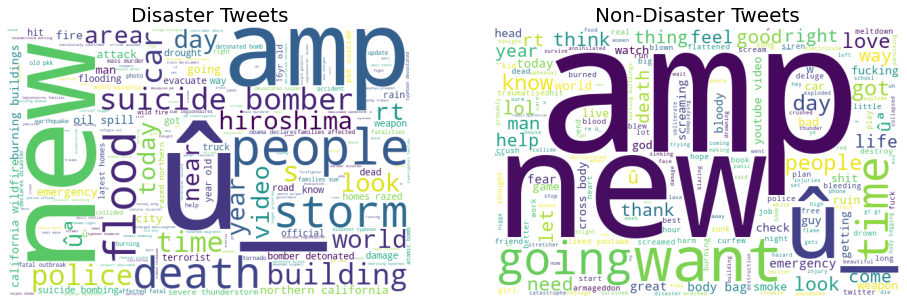

In [24]:
# Visualize in word cloud (After cleaning texts)

disaster_tweets = train_df[train_df['target']==1]['text']
non_disaster_tweets = train_df[train_df['target']==0]['text']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 8])
wordcloud1 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(disaster_tweets))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Disaster Tweets',fontsize=20);

wordcloud2 = WordCloud( background_color='white',
                        width=600,
                        height=400).generate(" ".join(non_disaster_tweets))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non-Disaster Tweets',fontsize=20);

#3. Datasets
- Train and test split
- Tokenize

In [14]:
task = "disaster_tweets"
model_checkpoint = "distilbert-base-uncased"
batch_size = 16

# 4. Train

## 4_1. Transformer model

### 4_1_1. Prepare Input
1. Train and Test Split
2. Tokenize
3. Dataset and Dataloader

In [25]:
# Train and Validation Split
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_df, test_size = 0.1, shuffle=True)

{0: 3921, 1: 2930}
Ratio: 0: 0.57, 1: 0.43


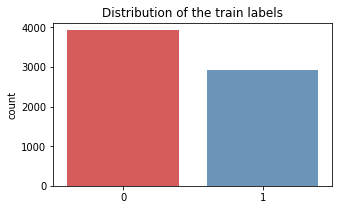

In [16]:
# Check balance in training set
target_info = dict(Counter(train_labels))
print(target_info)
plt.figure(figsize = (5,3))
sns.countplot(x = train_labels, palette = 'Set1', alpha = 0.8)
plt.title('Distribution of the train labels')
print(f"Ratio: 0: {target_info[0]/(target_info[0]+target_info[1]):.2}, 1: {target_info[1]/(target_info[0]+target_info[1]):.2}")

In [19]:
max(train_df.num_words)

31

In [20]:
# Tokenize using tokenizer from transformers of Huggingface
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
#tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint, do_lower_case=True)

In [21]:
def tokenize_df(tokenizer, df, has_label=True):
    """
    Function to directly create a list of dictonaries to be loaded into the model
    """
    # convert text to list
    texts = df['text'].tolist()
    # returns dictionary with keys: input_ids, attention_mask)
    encoding_dict = tokenizer(texts, padding="max_length", max_length=64,
                              truncation=True, return_token_type_ids=False)
    # add 'label' key if we are making train or validation data
    if has_label: 
        encoding_dict['label'] = df['target'].tolist()
        
    return [dict(zip(encoding_dict, t)) for t in zip(*encoding_dict.values())]

In [36]:
# apply above function to create lists to use for our data:
train_tokenized = tokenize_df(tokenizer, train)
val_tokenized = tokenize_df(tokenizer, val)
test_tokenized = tokenize_df(tokenizer, test_df, has_label=False)

### 4_1_2. Prepare Model

In [37]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [38]:
from transformers import AutoConfig, BertConfig

config = AutoConfig.from_pretrained(model_checkpoint, 
                                    attention_dropout = 0.4,
                                    dropout= 0.4,
                                    n_layers = 12
                                    )

'''
config = BertConfig.from_pretrained(model_checkpoint, 
                                    hidden_dropout_prob = 0.5, 
                                    num_labels=2)
'''

'\nconfig = BertConfig.from_pretrained(model_checkpoint, \n                                    hidden_dropout_prob = 0.5, \n                                    num_labels=2)\n'

In [39]:
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification, BertForSequenceClassification, TFBertForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)
#model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint, config=config)
#model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.transformer.layer.6.attention.q_lin.bias', 

### 4_1_3. By Trainer (HuggingFace)

In [40]:
import numpy as np
from datasets import load_metric
import evaluate
 
def compute_metrics_trainer(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
   
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    load_roc = evaluate.load("roc_auc")

    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, pos_label=1)["f1"]
    try: 
        roc_auc = load_roc.compute(references=labels, prediction_scores = logits[:,1])["roc_auc"]
    except ValueError:
        roc_auc = 0.0

    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

In [41]:
from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [43]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
 
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    output_dir = f"{model_name}-finetuned-{task}",
    learning_rate=5e-6,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy = "steps",
    eval_steps = 100,
    save_steps = 100,
    logging_steps = 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
   model=model,
   args=args,
   train_dataset=train_tokenized,
   eval_dataset=val_tokenized,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics_trainer,
   callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)


'''
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=False,
'''

'\n    per_device_train_batch_size=batch_size,\n    per_device_eval_batch_size=batch_size,\n    push_to_hub=False,\n'

In [44]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 6851
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8570


Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
100,0.621300,0.476378,0.771654,0.737160,0.858400
200,0.544700,0.445610,0.800525,0.767584,0.872691
300,0.488700,0.462556,0.812336,0.746004,0.872401
400,0.483200,0.435661,0.811024,0.767742,0.879296
500,0.512000,0.503541,0.783465,0.769874,0.885336
600,0.527600,0.443769,0.807087,0.777610,0.884283
700,0.518400,0.426073,0.811024,0.776398,0.885519
800,0.452400,0.429887,0.821522,0.774086,0.881140
900,0.465300,0.461545,0.813648,0.789941,0.886226
1000,0.434500,0.478132,0.822835,0.761062,0.882997


***** Running Evaluation *****
  Num examples = 762
  Batch size = 8


Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-100
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-100/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-100/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-100/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-200
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-200/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-200/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/checkpoint-200/tok

TrainOutput(global_step=2500, training_loss=0.4686792984008789, metrics={'train_runtime': 516.7035, 'train_samples_per_second': 132.591, 'train_steps_per_second': 16.586, 'total_flos': 657448749580800.0, 'train_loss': 0.4686792984008789, 'epoch': 2.92})

In [45]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 762
  Batch size = 8


{'eval_loss': 0.4653036296367645,
 'eval_accuracy': 0.8333333333333334,
 'eval_f1': 0.8018720748829953,
 'eval_roc_auc': 0.8905630788140801,
 'eval_runtime': 3.186,
 'eval_samples_per_second': 239.173,
 'eval_steps_per_second': 30.132,
 'epoch': 2.92}

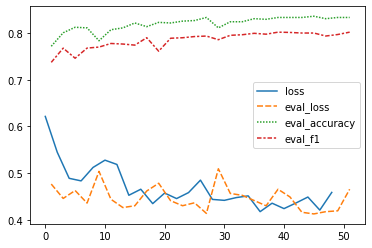

In [46]:
log_df = pd.DataFrame(trainer.state.log_history)
sns.lineplot(data=log_df[['loss', 'eval_loss', 'eval_accuracy', 'eval_f1']])

In [47]:
# make predictions:
predictions = trainer.predict(test_tokenized)
array_pred = predictions.predictions
y_pred = [np.argmax(pred) for pred in array_pred]
y_pred[:10]

***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


[1, 1, 1, 1, 1, 1, 0, 0, 0, 0]

In [50]:
test_df['target'] = y_pred
submissions = test_df[["id", "target"]]

In [55]:
submissions.to_csv("submission.csv", index=False)

In [54]:
submissions

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### 4_1_4. Parameter Search

In [61]:
def model_init():
    config = AutoConfig.from_pretrained(model_checkpoint, 
                                        attention_dropout = 0.4,
                                        dropout= 0.4,
                                        n_layers = 12
                                        )
    model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)
    return model

In [62]:
'''
args = TrainingArguments(
    output_dir = f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)
'''
args = TrainingArguments(
    output_dir = f"{model_name}-finetuned-{task}",
    learning_rate=5e-6,
    num_train_epochs=10,
    weight_decay=0.01,
    evaluation_strategy = "steps",
    eval_steps = 100,
    save_steps = 100,
    logging_steps = 100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
)

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,data_collator=data_collator,
    compute_metrics=compute_metrics_trainer,
   callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.4,
  "dim": 768,
  "dropout": 0.4,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 12,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_

In [ ]:
best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")

[I 2022-08-30 19:38:09,922] A new study created in memory with name: no-name-0d6f2596-6764-430b-a280-03220e5a94c1
Trial:
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.4,
  "dim": 768,
  "dropout": 0.4,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 12,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.c

Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
100,0.562500,0.510369,0.795276,0.698842,0.864497
200,0.568800,0.437692,0.809711,0.774495,0.878116
300,0.508600,0.451006,0.818898,0.757895,0.874987
400,0.495000,0.621211,0.778215,0.766252,0.884389
500,0.493700,0.487324,0.813648,0.785498,0.887363
600,0.472300,0.469173,0.809711,0.791966,0.888783
700,0.473700,0.424232,0.811024,0.767742,0.887886
800,0.490700,0.548774,0.787402,0.773109,0.890556
900,0.445600,0.435164,0.817585,0.777600,0.889171
1000,0.430900,0.617739,0.809711,0.787701,0.890351


***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-100
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-100/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-100/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-100/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-200
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-200/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-0/checkpoint-200/

Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
100,0.680200,0.576564,0.736220,0.578616,0.834354
200,0.613800,0.607895,0.778215,0.754003,0.820162
300,0.643300,0.589863,0.762467,0.751032,0.832941
400,0.567300,0.613143,0.803150,0.762658,0.849415
500,0.588900,0.616481,0.790026,0.768786,0.859725
600,0.575300,0.500494,0.808399,0.746528,0.866814
700,0.551300,0.479082,0.816273,0.771242,0.824086
800,0.579100,0.517665,0.779528,0.763380,0.874386
900,0.522100,0.568540,0.775591,0.761506,0.874768
1000,0.553400,0.480502,0.817585,0.763203,0.844671


***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-100
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-100/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-100/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-100/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-200
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-200/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-1/checkpoint-200/

Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
100,0.661500,0.616646,0.583990,0.036474,0.822338
200,0.621800,0.529355,0.778215,0.667976,0.852791
300,0.549200,0.447362,0.811024,0.755102,0.866736
400,0.507900,0.435189,0.817585,0.764007,0.869477
500,0.529000,0.424274,0.818898,0.774510,0.874923
600,0.485600,0.426847,0.814961,0.775835,0.878060
700,0.484900,0.430764,0.818898,0.784375,0.879169
800,0.494600,0.424769,0.825459,0.782324,0.879995
900,0.468500,0.432015,0.813648,0.756014,0.879006
1000,0.496300,0.419986,0.822835,0.773109,0.880977


***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-100
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-100/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-100/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-100/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-200
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-200/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-2/checkpoint-200/

Step,Training Loss,Validation Loss,Accuracy,F1,Roc Auc
100,0.601900,0.435318,0.812336,0.764415,0.871695
200,0.527700,0.444612,0.808399,0.782090,0.886395
300,0.520000,0.482652,0.790026,0.769452,0.882383
400,0.553600,0.427272,0.816273,0.783282,0.881189
500,0.474600,0.412040,0.829396,0.778912,0.883873
600,0.503900,0.471594,0.818898,0.793413,0.886960
700,0.490300,0.409952,0.826772,0.785016,0.886522
800,0.453900,0.442338,0.822835,0.756757,0.886176
900,0.482800,0.436521,0.822835,0.786054,0.891008
1000,0.450300,0.426640,0.826772,0.781457,0.887547


***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-100
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-100/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-100/pytorch_model.bin
tokenizer config file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-100/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-100/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 762
  Batch size = 8
Saving model checkpoint to distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-200
Configuration saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-200/config.json
Model weights saved in distilbert-base-uncased-finetuned-disaster_tweets/run-3/checkpoint-200/

In [ ]:
best_run

In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

trainer.train()

In [ ]:
# make predictions:
predictions = trainer.predict(test_tokenized)
array_pred = predictions.predictions
y_pred = [np.argmax(pred) for pred in array_pred]
y_pred[:10]

In [ ]:
test_df['target'] = y_pred
submissions = test_df[["id", "target"]]
submissions.to_csv("submission.csv", index=False)

###4_1_5. Custom training

In [ ]:
import numpy as np
from datasets import load_metric
import evaluate


def compute_metrics(logits, labels):
    predictions = np.argmax(logits, axis=-1)

    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    load_roc = evaluate.load("roc_auc")
   
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels, pos_label=1)["f1"]
    try: 
        roc_auc = load_roc.compute(references=labels, prediction_scores = logits[:,1])["roc_auc"]
    except ValueError:
        roc_auc = 0.0

    return {"accuracy": accuracy, "f1": f1, "roc_auc": roc_auc}

class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """
        :param val: value from the scores
        :param n  : batch_size
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
def train(train_loader, model, optimizer, lr_scheduler, epoch):
    model.train()
    losses = AverageMeter()
    acc = AverageMeter()
    f1 = AverageMeter()
    roc_auc = AverageMeter()

    for i, batch in enumerate(train_loader):
        # Forward
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Get Loss
        loss = outputs.loss
        logits = outputs.logits

        # Back prop.
        loss.backward()

        # Update weights
        optimizer.step()
        lr_scheduler.step()

        # Keep track of metrics
        scores = compute_metrics(logits, labels)
        losses.update(loss.item(), len(labels))
        acc.update(scores['accuracy'], len(labels))
        f1.update(scores['f1'], len(labels))
        roc_auc.update(scores['roc_auc'], len(labels))

    print(f"Epoch: {epoch}, Train Loss: {losses.avg:.2}, Acc: {acc.avg:.2}, F1: {f1.avg:.2}, ROC: {roc_auc.avg:.2}")
    return losses.avg, acc.avg, f1.avg, roc_auc.avg


def validate(val_loader, model, epoch):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    f1 = AverageMeter()
    roc_auc = AverageMeter()

    with torch.no_grad():

        for i, batch in enumerate(val_loader):
            # Forward
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            # Get Loss
            loss = outputs.loss
            logits = outputs.logits

            # Keep track of metrics
            scores = compute_metrics(logits, labels)
            losses.update(loss.item(), len(labels))
            acc.update(scores['accuracy'], len(labels))
            f1.update(scores['f1'], len(labels))
            roc_auc.update(scores['roc_auc'], len(labels))

    print(f"Epoch: {epoch}, Val Loss: {losses.avg:.2}, Acc: {acc.avg:.2}, F1: {f1.avg:.2}, ROC: {roc_auc.avg:.2}")
    return losses.avg, acc.avg, f1.avg, roc_auc.avg



In [ ]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size = 16)
EPOCHS = 5
num_training_steps = EPOCHS * len(train_loader)
learning_rate=5e-6

#model = DistilBertForSequenceClassification.from_pretrained(model_checkpoint)
config = AutoConfig.from_pretrained(model_checkpoint, 
                                    attention_dropout = 0.4,
                                    dropout= 0.4,
                                    n_layers = 12
                                    )

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, config=config)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay = 0.01)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.4,
  "dim": 768,
  "dropout": 0.4,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 12,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.21.2",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5

In [ ]:
model.to(DEVICE)

metrics = {}
metrics['train_losses'] = []
metrics['train_acc'] = []
metrics['train_f1'] = []
metrics['train_roc'] = []
metrics['val_losses'] = []
metrics['val_acc'] = []
metrics['val_f1'] = []
metrics['val_roc'] = []
best_model = None
best_optim = None
best_model_state_dict = None
best_optim_state_dict = None

best_f1 = 0.0


for epoch in range(1, EPOCHS+1):
    train_loss, train_acc, train_f1, train_roc = train(train_loader = train_loader, model = model, optimizer = optimizer, lr_scheduler=lr_scheduler, epoch=epoch)
    metrics['train_losses'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['train_f1'].append(train_f1)
    metrics['train_roc'].append(train_roc)

    val_loss, val_acc, val_f1, val_roc = validate(val_loader = val_loader, model = model, epoch=epoch)
    metrics['val_losses'].append(val_loss)
    metrics['val_acc'].append(val_acc)
    metrics['val_f1'].append(val_f1)
    metrics['val_roc'].append(val_roc)
    if val_f1 > best_f1:
        best_model = model
        best_optim = optimizer
        best_model_state_dict = model.state_dict()
        best_optim_state_dict = optimizer.state_dict()


Epoch: 1, Train Loss: 0.53, Acc: 0.74, F1: 0.63, ROC: 0.78
Epoch: 1, Val Loss: 0.48, Acc: 0.79, F1: 0.76, ROC: 0.87
Epoch: 2, Train Loss: 0.46, Acc: 0.79, F1: 0.72, ROC: 0.85
Epoch: 2, Val Loss: 0.45, Acc: 0.81, F1: 0.77, ROC: 0.87
Epoch: 3, Train Loss: 0.44, Acc: 0.8, F1: 0.73, ROC: 0.86
Epoch: 3, Val Loss: 0.45, Acc: 0.81, F1: 0.78, ROC: 0.87
Epoch: 4, Train Loss: 0.44, Acc: 0.81, F1: 0.74, ROC: 0.86
Epoch: 4, Val Loss: 0.44, Acc: 0.81, F1: 0.78, ROC: 0.88
Epoch: 5, Train Loss: 0.42, Acc: 0.82, F1: 0.76, ROC: 0.87
Epoch: 5, Val Loss: 0.45, Acc: 0.82, F1: 0.79, ROC: 0.88


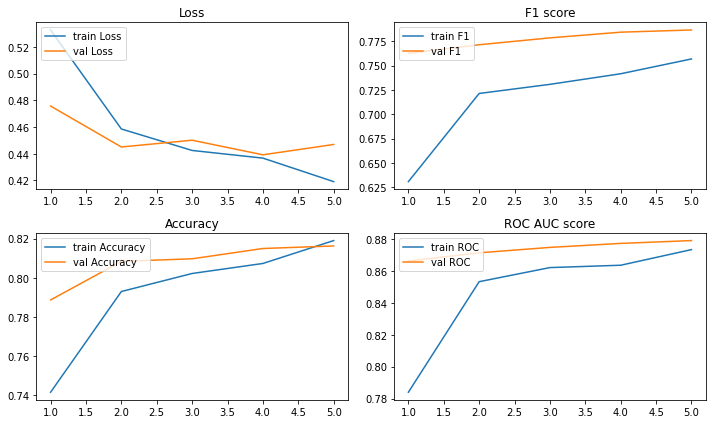

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 6))
epochs = list(range(1, EPOCHS+1))

axs[0, 0].plot(epochs, metrics['train_losses'], label='train Loss')
axs[0, 0].plot(epochs, metrics['val_losses'], label='val Loss')
axs[0, 0].set_title("Loss")
axs[0, 0].legend(loc='upper left')

axs[1, 0].plot(epochs, metrics['train_acc'], label='train Accuracy')
axs[1, 0].plot(epochs, metrics['val_acc'], label='val Accuracy')
axs[1, 0].set_title("Accuracy")
axs[1, 0].legend(loc='upper left')

axs[0, 1].plot(epochs, metrics['train_f1'], label='train F1')
axs[0, 1].plot(epochs, metrics['val_f1'], label='val F1')
axs[0, 1].set_title("F1 score")
axs[0, 1].legend(loc='upper left')

axs[1, 1].plot(epochs, metrics['train_roc'], label='train ROC')
axs[1, 1].plot(epochs, metrics['val_roc'], label='val ROC')
axs[1, 1].set_title("ROC AUC score")
axs[1, 1].legend(loc='upper left')

fig.tight_layout()



In [ ]:
state = {'epoch': epoch,
         'metrics': metrics,
         'model': best_model,
         'model_state_dict': best_model.state_dict(),
         'optimizer': best_optim,
         'optimizer_state_dict': best_optim.state_dict()
         }
filename = "disaster_tweets_220830.pth.tar"
torch.save(state, filename)

##4_2. Other Methdologies (Other ML models)

In [ ]:
## ML Library
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import pickle

## Ignoring Warning during trainings 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
cv_texts = train_df['text']
cv_labels = train_df['target']
cv_texts = cv_texts.tolist()
cv_labels = cv_labels.tolist()


In [ ]:
#stemmering the text and joining
stemmer = nltk.stem.PorterStemmer()
cv_texts=cv_texts.apply(lambda x:" ".join(stemmer.stem(token) for token in x))

0            deed reason earthquak may allah forgiv us
1                 forest fire near la rong sask canada
2    resid ask shelter place notifi offic evacu she...
3          peopl receiv wildfir evacu order california
4    got sent photo rubi alaska smoke wildfir pour ...
Name: text, dtype: object

In [ ]:
count_vectorizer = CountVectorizer()
train_vectors_count = count_vectorizer.fit_transform(cv_texts)

In [ ]:
import statistics

# Fitting a simple Logistic Regression on Counts
CLR = LogisticRegression(C=2)
scores = cross_val_score(CLR, train_vectors_count, cv_labels, cv=10, scoring="f1")
statistics.mean(scores)

array([0.64069264, 0.53245532, 0.59334566, 0.49111808, 0.59638554,
       0.7183908 ])

In [ ]:
# Fitting a simple Naive Bayes
NB_Vec = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(NB_Vec, train_vectors_count, cv_labels, cv=cv, scoring="f1")
statistics.mean(scores)

array([0.77127244, 0.75604053, 0.74760383, 0.74822415, 0.76228209,
       0.75396825, 0.75545171, 0.75917065, 0.75851148, 0.75409836,
       0.74584323, 0.74451411, 0.76682316, 0.75911252, 0.75862069])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

RF = RandomForestClassifier()
scores = cross_val_score(RF, train_vectors_count, train_labels, cv=cv, scoring="f1")
statistics.mean(scores)

array([0.75459098, 0.74957411, 0.7260274 , 0.73187184, 0.6975945 ,
       0.73063973, 0.71944923, 0.72852234, 0.71157168, 0.73063973,
       0.71717172, 0.74956822, 0.72635135, 0.71034483, 0.73187184,
       0.72027972, 0.74523397, 0.74529915, 0.69059829, 0.74036851,
       0.75496689, 0.7238422 , 0.73648649, 0.7427598 , 0.73648649,
       0.72053872, 0.71088435, 0.71527778, 0.73129252, 0.73559322])